In [11]:
import numpy as np
import data_gen
import nnDON
import pickle
import torch.utils.data as data_0
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint

In [12]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)


In [ ]:
## setting parameters of ODE problem
T = 1
M = 300
y0 = 0
domain = np.linspace(-T, T, M)

## parameters for data generator
N = 3000
order = 20

## generate and save dataset
train_raw_set = data_gen.raw_data_generator(N, order, domain, y0)
createFolder('./data')
with open("./data/NI_data.pickle","wb") as fw:
    pickle.dump(train_raw_set, fw)

In [ ]:

## load dataset
with open("./data/NI_data.pickle","rb") as fr:
    train_raw_set_loaded = pickle.load(fr)

## construct train data loader
Batch_size = 10000
tr_dataset = data_gen.Dataset(train_raw_set_loaded['train_X'].cuda().float(), train_raw_set_loaded['train_Y'].cuda().float())
train_loader = data_0.DataLoader(tr_dataset, batch_size=Batch_size, shuffle=False)


In [13]:
## is cuda available?
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## parameters for Neural Network
width = 256
depth = 3
P = 64

## define a model
model = nnDON.DON(M, width, depth, P).cuda()

In [14]:

## setting hyperparameters
learning_rate = 0.001
num_epochs = 500

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)



C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_7120/2300854556.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [ ]:

## training model

trainloss = []

createFolder('./models')

for epoch in range(num_epochs):
    
    tloss = 0
    
    n = 0
    for batch in train_loader:
        
        x, y = batch
        output = model(x)
        optimizer.zero_grad()
        loss = criterion(y, output)
        loss.backward()
        optimizer.step()
        tloss += loss.detach().cpu().numpy()
    
        with torch.no_grad():
            torch.cuda.empty_cache()
            
        n += 1
    
    ## save best model
    if epoch != 0:
        if tloss < trainloss[epoch-1]:
            torch.save(model.state_dict(), './models/model.pt')
        
    trainloss.append(tloss)
    
    if epoch % 10 == 0:
        print('epoch {} loss : {:.4}'.format(epoch,trainloss[epoch]))
    

In [ ]:
## plot loss
plt.plot(trainloss)
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [15]:
## load best model
model.load_state_dict(torch.load('./models/model.pt'))


<All keys matched successfully>

Text(0.5, 1.0, 'comparison')

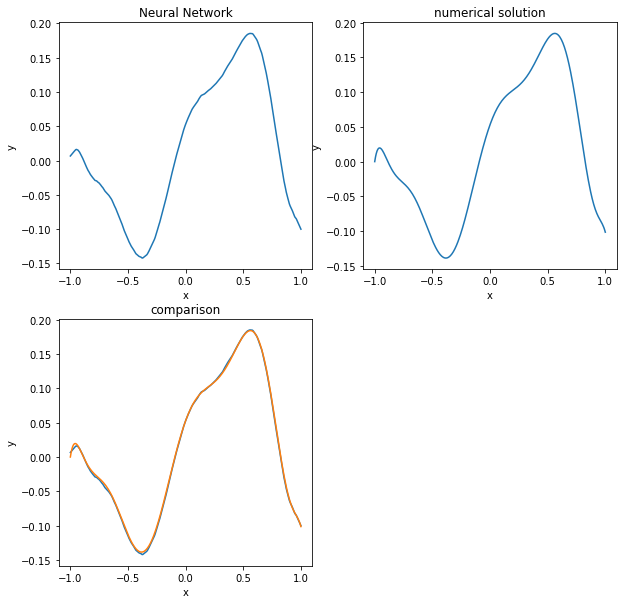

In [20]:

## demonstrating by example
def func(y, t, c):
    return np.polynomial.chebyshev.Chebyshev(c)(t)

c = [np.random.rand(10)-0.5]
x = np.polynomial.chebyshev.Chebyshev(c[0])(domain)
y = odeint(func, 0, domain, args = tuple(c))

result =  []
for i in domain:
    result.append(model(torch.cat((torch.tensor(x), torch.tensor([i]))).reshape(1,M+1).cuda().float()).cpu().detach().numpy())
    
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)  
plt.plot(domain, result)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network')
plt.subplot(2, 2, 2)  
plt.plot(domain, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('numerical solution')
plt.subplot(2, 2, 3)  
plt.plot(domain, result)
plt.plot(domain, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('comparison')